In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import Lasso
import warnings
import seaborn as sns
from scipy.optimize import minimize
import copy

<h1>Hyperparameters<h1>


In [147]:
K = 5 # validation folds
MIN_LAG = 134
MAX_LAG = 168
SEED = 42
VAL_SPLIT = 0.15

In [148]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

<h1>Creating DataFrames<h1>

In [149]:
spot_prices = pd.read_csv("spotpriser.csv").set_index("time")
consumption = pd.read_csv("consumption_temp_with_flags.csv").set_index("time")

oslo_consumption = consumption[consumption["location"] == "oslo"]
oslo_consumption = oslo_consumption.merge(spot_prices["oslo"], left_index=True, right_index=True, how="left")
oslo_consumption=oslo_consumption.drop(['location'],axis=1).rename(columns={'oslo':'spot_price'})

stavanger_consumption = consumption[consumption["location"] == "stavanger"]
stavanger_consumption = stavanger_consumption.merge(spot_prices["stavanger"], left_index=True, right_index=True, how="left")
stavanger_consumption=stavanger_consumption.drop(['location'],axis=1).rename(columns={'stavanger':'spot_price'})

trondheim_consumption = consumption[consumption["location"] == "trondheim"]
trondheim_consumption = trondheim_consumption.merge(spot_prices["trondheim"], left_index=True, right_index=True, how="left")
trondheim_consumption=trondheim_consumption.drop(['location'],axis=1).rename(columns={'trondheim':'spot_price'})

tromso_consumption = consumption[consumption["location"] == "tromsø"]
tromso_consumption = tromso_consumption.merge(spot_prices["tromsø"], left_index=True, right_index=True, how="left")
tromso_consumption=tromso_consumption.drop(['location'],axis=1).rename(columns={'tromsø':'spot_price'})

bergen_consumption = consumption[consumption["location"] == "bergen"]
bergen_consumption = bergen_consumption.merge(spot_prices["bergen"], left_index=True, right_index=True, how="left")
bergen_consumption=bergen_consumption.drop(['location'],axis=1).rename(columns={'bergen':'spot_price'})
    

<h1>Feature engineering<h1>

In [150]:
DFS = [oslo_consumption,stavanger_consumption,trondheim_consumption,tromso_consumption,bergen_consumption]
DFS_orig = copy.deepcopy(DFS)
DF_STRINGS = ["Oslo","Stavanger","Trondheim","Tromsø","Bergen"]

cols_to_standard_normal = ["temperature","consumption"]
cols_to_normalize_01 = ["consumption","spot_price"]
columns_to_decompose = ['temperature', 'spot_price','consumption']
cols_to_diff = []
REVERSE_CONSUMPTION_NORMALIZATION = [] #note: Same order as consumption_dfs
for i in range(len(DFS)):
    DFS[i].index = pd.to_datetime(DFS[i].index)
DFS_orig = copy.deepcopy(DFS)

In [151]:
def lag_columns(df, min_lag,max_lag, columns):
    for col in columns:
        if col in df.columns:
            for lag in range(min_lag,max_lag+1):
                df[f"{col}_L{lag}"] =  df[col].shift(lag)
            if col not in ['consumption_seasonal', 'consumption_trend']:
                df.drop(col, axis=1) 
    return df.dropna(axis=0)


def decompose_time_series(df, columns_to_decompose=columns_to_decompose, period=24):
    for col in columns_to_decompose:
        if col in df.columns:
            # Decompose the time series
            result = seasonal_decompose(df[col], model='additive', period=period)

            # Create new columns for trend and seasonal components
            df[f"{col}_trend"] = result.trend
            df[f"{col}_seasonal"] = result.seasonal

            # Drop the original column
            df.drop(col, axis=1, inplace=True)
        else:
            print(f"Column '{col}' not found in DataFrame.")
    
    return df

def add_interaction_column(df,col1, col2):
    df[f"{col1}_X_{col2}"] = df[col1]*df[col2]
    return df.dropna() 

In [152]:
for i in range(len(DFS)):
    DFS[i].dropna(axis=0, inplace=True)
    DFS[i]["is_holiday"] = DFS[i]["is_holiday"].astype(int)
    DFS[i]["is_weekend"] = DFS[i]["is_weekend"].astype(int)
    
    DFS[i]["hour"] = np.cos(DFS[i].index.hour*np.pi/12)
    DFS[i]["month"] = np.cos(DFS[i].index.month*np.pi/6)

    for col in cols_to_standard_normal:
        mu, sig = DFS[i][col].mean(), DFS[i][col].std()
        if col == "consumption":
            REVERSE_CONSUMPTION_NORMALIZATION.append([mu,sig])
        DFS[i][col] = (DFS[i][col]-mu)/sig
    for col in cols_to_normalize_01:
        DFS[i][col] = (DFS[i][col]-DFS[i][col].min())/(DFS[i][col].max()-DFS[i][col].min())
    DFS[i] = decompose_time_series(DFS[i])
    DFS[i] = lag_columns(DFS[i], min_lag=38,max_lag = MAX_LAG, columns=["temperature_trend", "temperature_seasonal", "spot_price_trend", "spot_price_seasonal"])
    DFS[i] = lag_columns(DFS[i], min_lag=MIN_LAG,max_lag = MAX_LAG, columns=["consumption_trend","consumption_seasonal"])
    DFS[i] = add_interaction_column(DFS[i], "hour", "is_weekend")
    DFS[i] = add_interaction_column(DFS[i], "month", "is_weekend")
    DFS[i] = add_interaction_column(DFS[i], "hour", "is_holiday")
    DFS[i] = add_interaction_column(DFS[i], "month", "is_holiday")
    DFS[i] = DFS[i].dropna(axis=0)
    DFS[i]["consumption_seasonal"] = DFS[i]["consumption_seasonal"]-DFS[i]["consumption_seasonal_L168"]
    DFS[i]["consumption_trend"] = DFS[i]["consumption_trend"]-DFS[i]["consumption_trend_L168"]


/var/folders/qq/swkbps694sxgbbm7j_cjk0mr0000gn/T/ipykernel_16453/1014637254.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{col}_L{lag}"] =  df[col].shift(lag)
/var/folders/qq/swkbps694sxgbbm7j_cjk0mr0000gn/T/ipykernel_16453/1014637254.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{col}_L{lag}"] =  df[col].shift(lag)
/var/folders/qq/swkbps694sxgbbm7j_cjk0mr0000gn/T/ipykernel_16453/1014637254.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

<h1>Training<h1>

In [153]:
# k-Fold for validation
k = 4
np.random.seed(SEED)


def avoid_spillover_split(X,offset):
    length = len(X)
    indices = np.arange(offset, length+1, MAX_LAG+1)
    return X.iloc[indices]

def custom_train_val_split(data, val_split):
    thresh = np.floor(len(data) * (1 - val_split)).astype(int)
    return data.iloc[:thresh], data.iloc[thresh:]

In [154]:
def soft_abs(z,eps):
    return np.sqrt(z**2+eps) - np.sqrt(eps)

def generate_weight_vector(x):
    n = len(x)
    v = [0.99 ** (n-1 - i ) for i in range(n)]
    v = v/np.mean(v)
    return v

In [155]:

def cross_validate(data,alpha1,alpha2,mu,sig,MAPEfac,initVarianceFac,abs_softness, I):
    # Lasso with MAPE Loss
    def lasso_mape_loss(w, X, y_true, alpha):
        v = generate_weight_vector(y_true)
        y_pred = X @ w
        return np.mean(v*soft_abs((y_true - y_pred)/(y_true+MAPEfac),abs_softness)) + alpha * np.sum(soft_abs(w,2**(-20)))/np.mean(y_true+MAPEfac)
    mape_values = []
    L = len(data)
    offsets = range(1,L,int(np.floor(L/k)))
    for offset in offsets:
        X = data.iloc[offset:int(offset + np.floor(L/k))]
        y1 = X["consumption_seasonal"]
        y2 = X["consumption_trend"]
        X = X.drop(columns = ["consumption_seasonal","consumption_trend"])
        X_train, X_val = custom_train_val_split(X, VAL_SPLIT)
        y1_train, y1_val = custom_train_val_split(y1, VAL_SPLIT)
        y2_train, y2_val = custom_train_val_split(y2, VAL_SPLIT)
        
        tol = 0.1
        n_features = X_train.shape[1]
        w_initial1 = np.random.randn(n_features)/initVarianceFac # Set small coefficients to zero, add noise 
        w_initial2 = np.random.randn(n_features)/initVarianceFac # Set small coefficients to zero, add noise 
        result = minimize(lasso_mape_loss, w_initial1, args=(X_train, y1_train, alpha1), method='L-BFGS-B', options={"tol":tol})
        w_optimal_1 = result.x
        result = minimize(lasso_mape_loss, w_initial2, args=(X_train, y2_train, alpha2), method='L-BFGS-B', options={"tol":tol})
        w_optimal_2 = result.x

        y1_pred = X_val @ w_optimal_1
        y2_pred = X_val @ w_optimal_2

        temp_df = pd.merge(y1_val,X_val["consumption_seasonal_L168"], how = "inner", left_index=True, right_index=True)
        temp_df = pd.merge(temp_df,X_val["consumption_trend_L168"], how = "inner", left_index=True, right_index=True)

        mape = np.mean(np.abs(((y1_val+y2_val)*sig - (y1_pred+y2_pred)*sig) / ((y1_val+y2_val + temp_df["consumption_trend_L168"]+temp_df["consumption_seasonal_L168"])*sig+mu))) * 100
        mape_values.append(mape)
    average_mape = np.mean(mape_values)
    return average_mape

Oslo
Alpha1, alpha2, MAPEfac, initVarianceFac abs_softness--> MAPE
4.76837158203125e-07 1.52587890625e-05 10 100 0.5--> 2.9224193246691104
4.76837158203125e-07 1.52587890625e-05 10 100 2--> 2.828524134793101
4.76837158203125e-07 1.52587890625e-05 10 100 4--> 2.7100707404323
4.76837158203125e-07 6.103515625e-05 10 100 0.5--> 2.567840526946965
4.76837158203125e-07 6.103515625e-05 10 100 2--> 2.709606662711947
4.76837158203125e-07 6.103515625e-05 10 100 4--> 2.381043514674514
4.76837158203125e-07 0.000244140625 10 100 0.5--> 2.8814552147635726
4.76837158203125e-07 0.000244140625 10 100 2--> 2.9011309332063417
4.76837158203125e-07 0.000244140625 10 100 4--> 2.451825352377064
4.76837158203125e-07 0.0009765625 10 100 0.5--> 2.642412994274478
4.76837158203125e-07 0.0009765625 10 100 2--> 2.6312627915407356
4.76837158203125e-07 0.0009765625 10 100 4--> 2.8292976528687883
3.814697265625e-06 1.52587890625e-05 10 100 0.5--> 2.5503028356703417
3.814697265625e-06 1.52587890625e-05 10 100 2--> 2.510

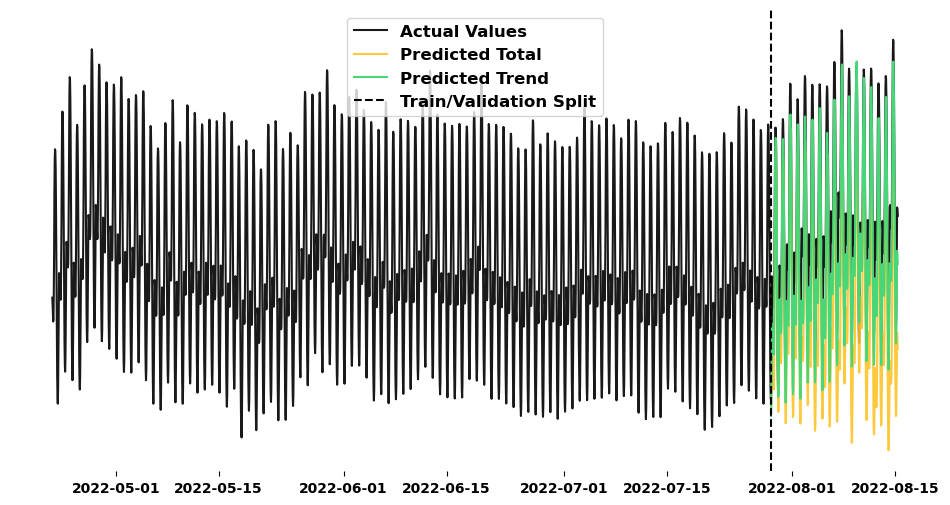

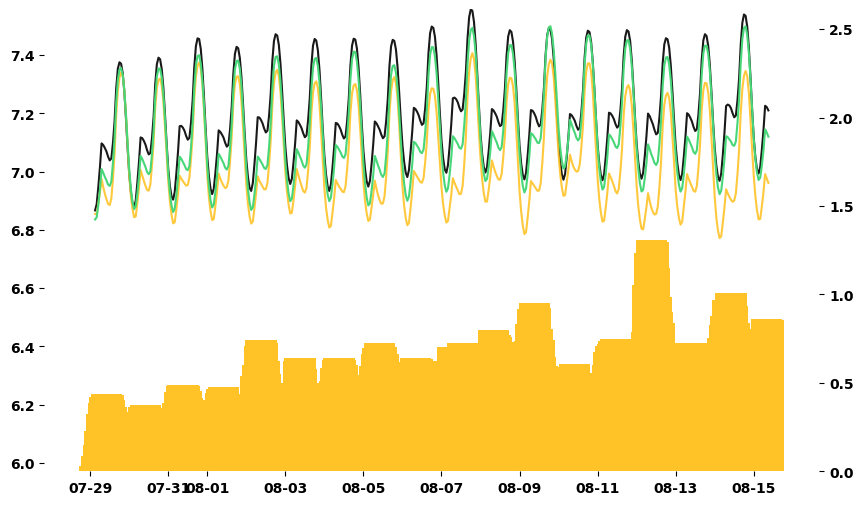

Error95: 0.035601650755042034
Out of sample MAPE: 2.162465221052332
Mean oveprediction: 0.1404548293853274
Mean underprediction: 2.177188597690684
MAPE with trend prediction only: 0.8685162159372605
Coefficients: 
is_holiday: 0.037548473817586706
is_weekend: -0.016370562339807746
hour: -0.00903305774985042
month: -0.05032465629220379
temperature_trend: -0.041525723245089956
temperature_seasonal: -0.06491028101468875
spot_price_trend: -0.05304266996056262
spot_price_seasonal: -0.017023034729869584
temperature_trend_L38: -0.12187124124986146
temperature_trend_L39: -0.021540535913080708
temperature_trend_L40: -0.07618340125978432
temperature_trend_L41: 0.06613099333824314
temperature_trend_L42: 0.0886894018462054
temperature_trend_L43: 0.04558133913460487
temperature_trend_L44: 0.04883292674921751
temperature_trend_L45: -0.02147591224440678
temperature_trend_L46: 0.014493983213520351
temperature_trend_L47: -0.028775108447847347
temperature_trend_L48: -0.003466180975365098
temperature_tren

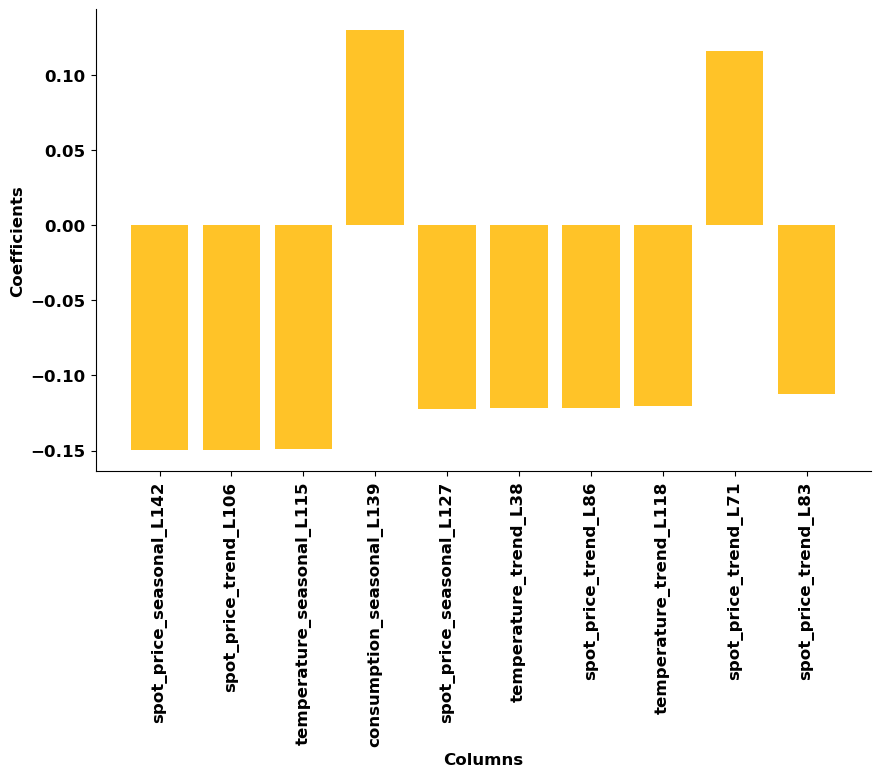

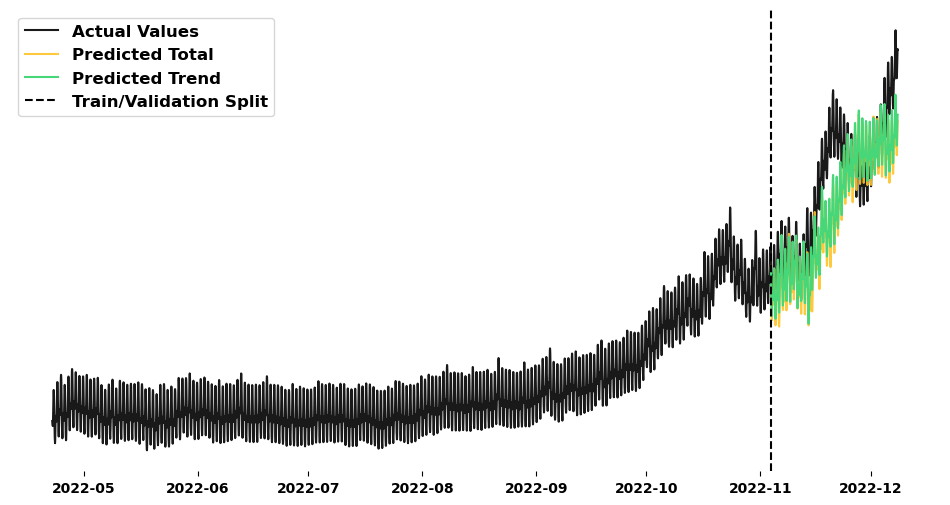

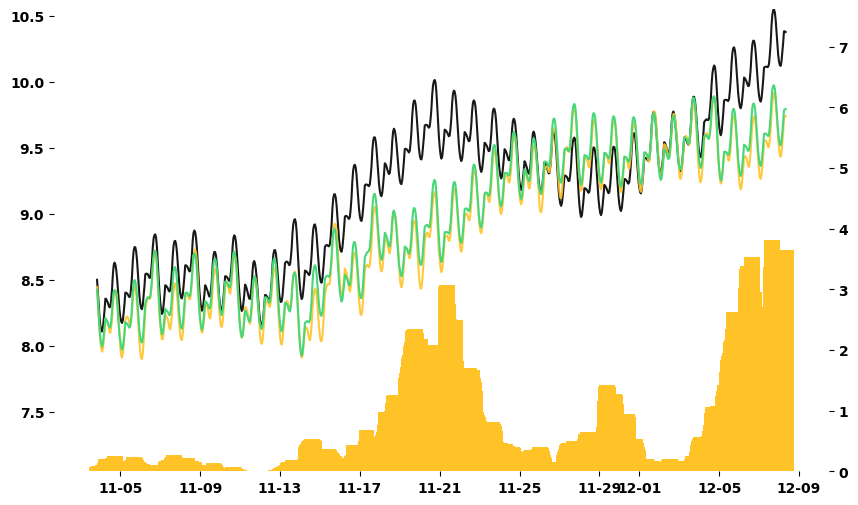

Error95: 0.08465230782520877
Out of sample MAPE: 3.4705715979952103
Mean oveprediction: 1.4218506206052715
Mean underprediction: 3.8832849543099957
MAPE with trend prediction only: 3.1024569295288984
Coefficients: 
is_holiday: -0.09154383833720071
is_weekend: 0.03761294899449745
hour: 0.07708624698609691
month: -0.1553846867685268
temperature_trend: -0.07698044285292102
temperature_seasonal: 0.01952570757596061
spot_price_trend: 0.05511072532837371
spot_price_seasonal: -0.003976694958748659
temperature_trend_L38: -0.003512665942419111
temperature_trend_L39: -0.05871297499403034
temperature_trend_L40: 0.023556291321845235
temperature_trend_L41: -0.01386695397582492
temperature_trend_L42: 0.0736657906519835
temperature_trend_L43: -0.09738541900558734
temperature_trend_L44: 0.006961186643967275
temperature_trend_L45: 0.020410573324064128
temperature_trend_L46: -0.020828449580402895
temperature_trend_L47: -0.00545885605649716
temperature_trend_L48: -0.002165743508693708
temperature_trend_L

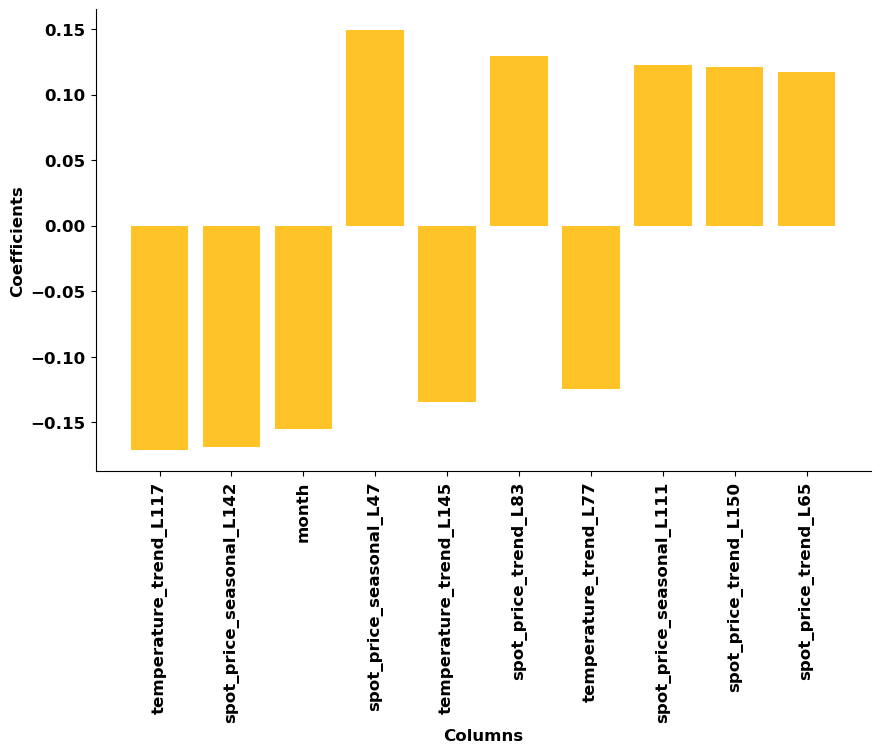

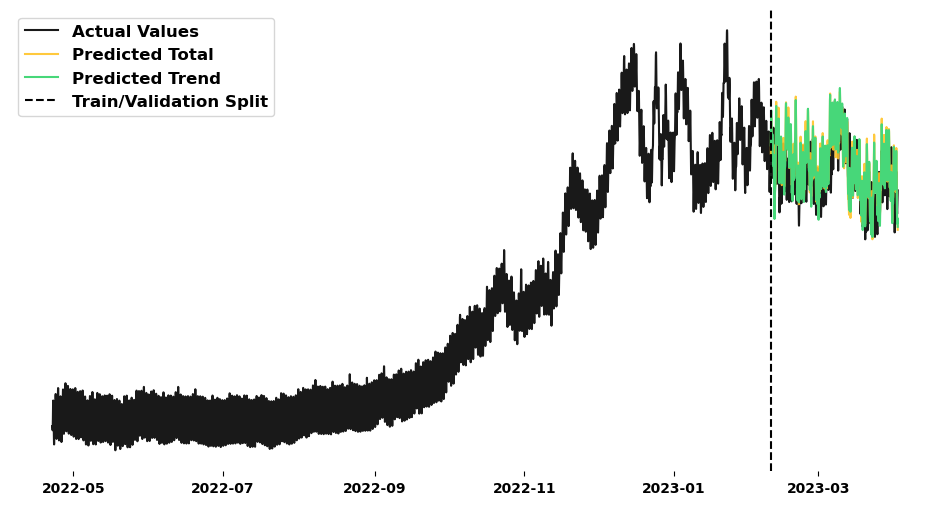

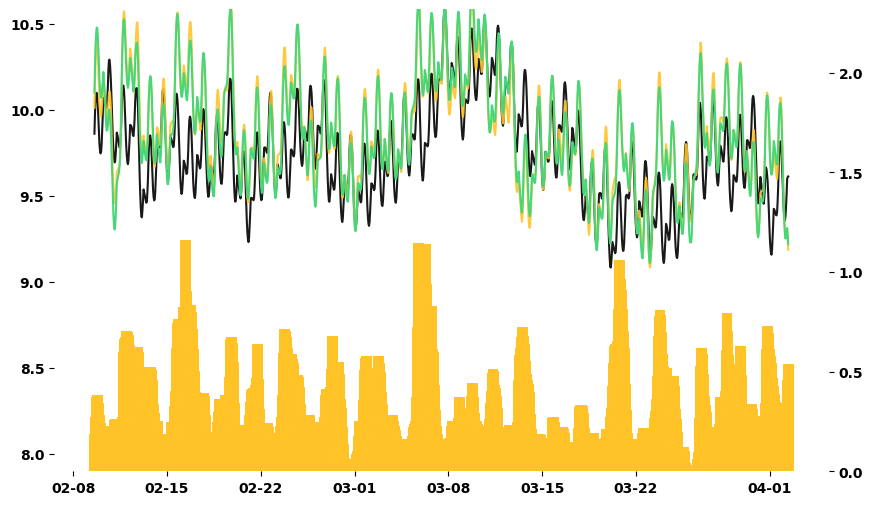

Error95: 0.052759017300910135
Out of sample MAPE: 2.109167544222773
Mean oveprediction: 2.4463526600183294
Mean underprediction: 1.313592933170012
MAPE with trend prediction only: 2.068881862807679
Coefficients: 
is_holiday: -0.058448695491548595
is_weekend: -0.04059250943043156
hour: 0.007652081310489884
month: 0.016570821082410363
temperature_trend: -0.5508888080290261
temperature_seasonal: -0.05929831941226415
spot_price_trend: 0.09099468647286217
spot_price_seasonal: -0.012468244831609366
temperature_trend_L38: -0.10671895124686381
temperature_trend_L39: 0.029088416567621143
temperature_trend_L40: 0.02533003299691849
temperature_trend_L41: -0.07623494293436045
temperature_trend_L42: -0.07949722613581044
temperature_trend_L43: -0.05843817275852681
temperature_trend_L44: -0.050147374435625454
temperature_trend_L45: -0.05082746567679446
temperature_trend_L46: 0.03803967603307008
temperature_trend_L47: 0.006231257403179136
temperature_trend_L48: 0.046242440743531295
temperature_trend_L

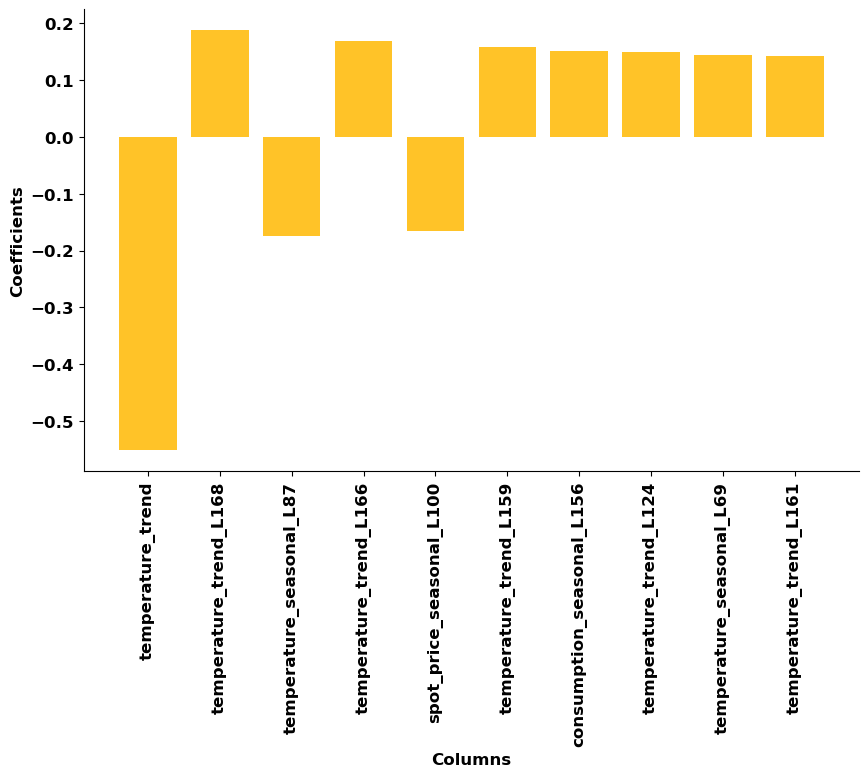

Stavanger
Alpha1, alpha2, MAPEfac, initVarianceFac abs_softness--> MAPE
4.76837158203125e-07 1.52587890625e-05 10 100 0.5--> 2.3589777072929263
4.76837158203125e-07 1.52587890625e-05 10 100 2--> 2.424658047529808
4.76837158203125e-07 1.52587890625e-05 10 100 4--> 2.6344637264767523
4.76837158203125e-07 6.103515625e-05 10 100 0.5--> 3.0773008608161985
4.76837158203125e-07 6.103515625e-05 10 100 2--> 2.128287981727379
4.76837158203125e-07 6.103515625e-05 10 100 4--> 2.3758614842719403
4.76837158203125e-07 0.000244140625 10 100 0.5--> 2.721832617050041
4.76837158203125e-07 0.000244140625 10 100 2--> 2.8261698352669478
4.76837158203125e-07 0.000244140625 10 100 4--> 3.247018174873093
4.76837158203125e-07 0.0009765625 10 100 0.5--> 3.099659592297209
4.76837158203125e-07 0.0009765625 10 100 2--> 3.1402396547420164
4.76837158203125e-07 0.0009765625 10 100 4--> 3.184600976733323
3.814697265625e-06 1.52587890625e-05 10 100 0.5--> 2.6040031325390753
3.814697265625e-06 1.52587890625e-05 10 100 2-

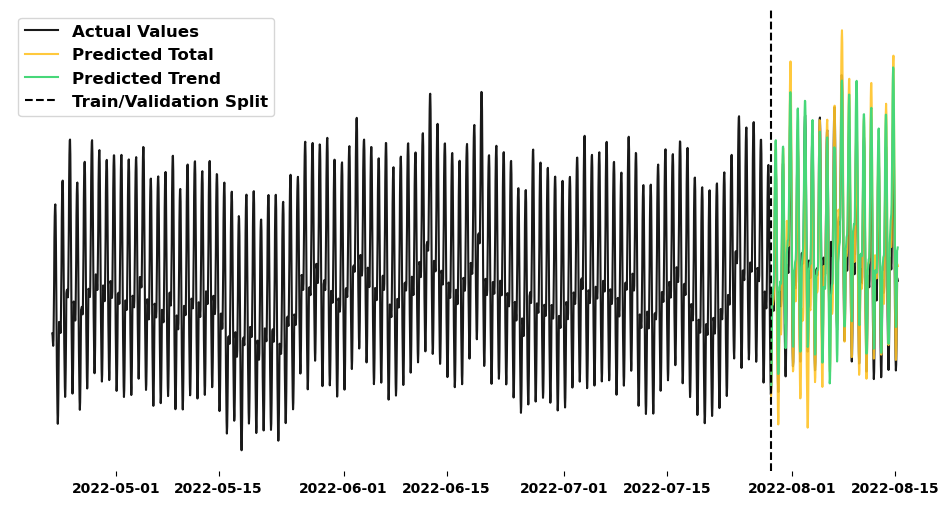

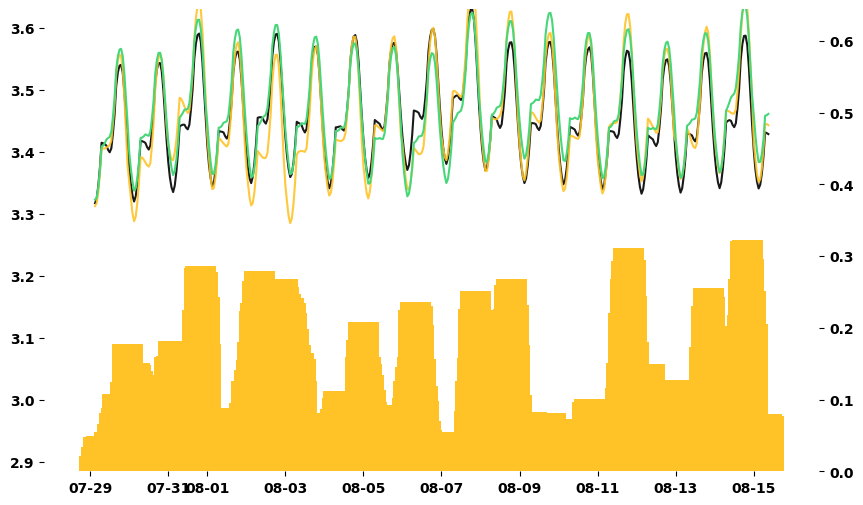

Error95: 0.0165778179168298
Out of sample MAPE: 0.6481715215750875
Mean oveprediction: 0.6255344598311924
Mean underprediction: 0.6739591022214836
MAPE with trend prediction only: 0.7093749196685716
Coefficients: 
is_holiday: 0.006050223883877477
is_weekend: 0.03278126948283365
hour: -0.010583155202755427
month: 0.005383270965974901
temperature_trend: -0.023884631012869206
temperature_seasonal: -0.027684406917263087
spot_price_trend: -0.02148598031569624
spot_price_seasonal: 0.001315057828343073
temperature_trend_L38: 0.01282208193225409
temperature_trend_L39: -0.030458928064809734
temperature_trend_L40: 0.025289635628108546
temperature_trend_L41: -0.03791407862889205
temperature_trend_L42: 0.01387639671880741
temperature_trend_L43: -0.04485773199020772
temperature_trend_L44: 0.022368083350331323
temperature_trend_L45: -0.016918721713135385
temperature_trend_L46: 0.024108587885790643
temperature_trend_L47: 0.007349865883115855
temperature_trend_L48: -0.007394470822299537
temperature_tr

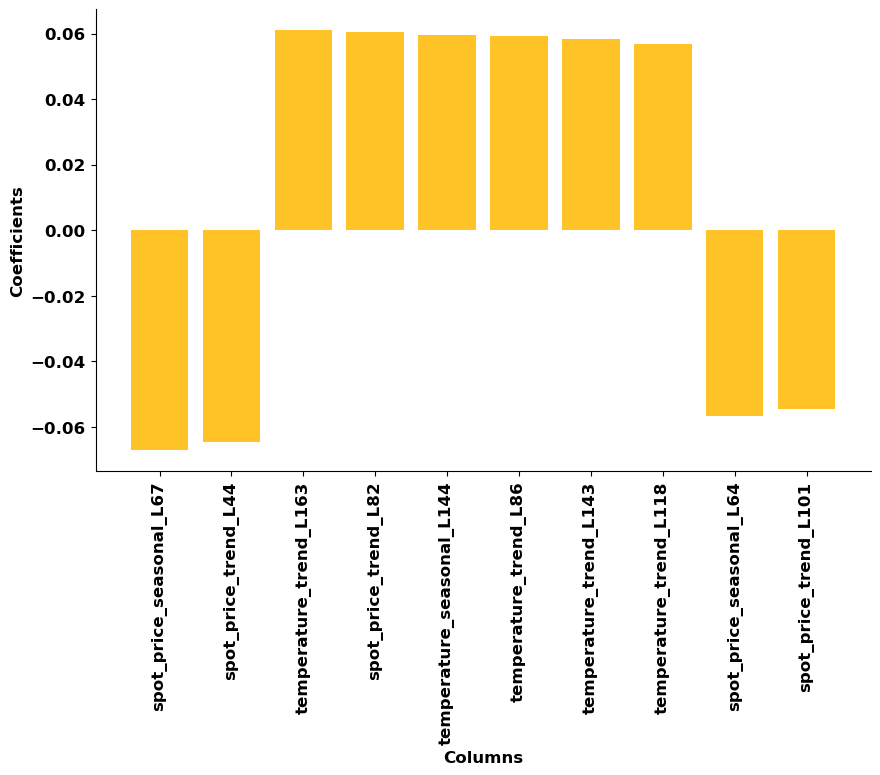

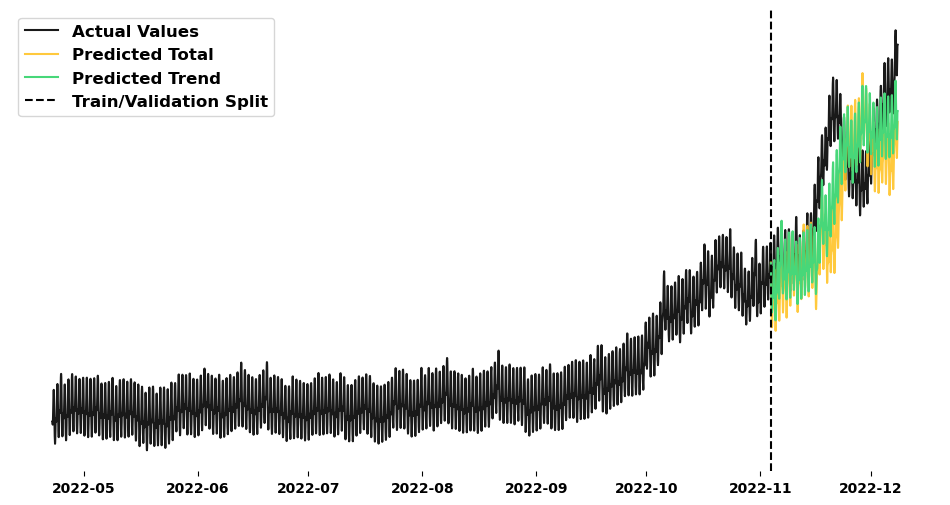

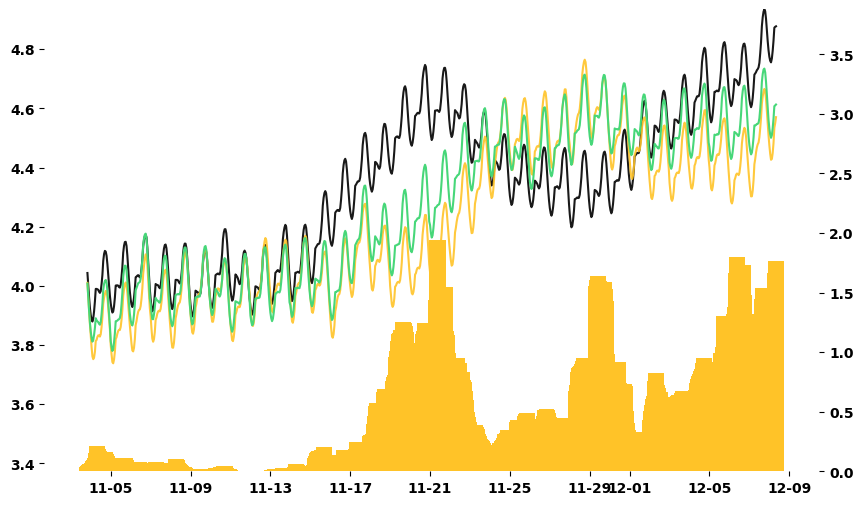

Error95: 0.10618485657308539
Out of sample MAPE: 4.264173290702387
Mean oveprediction: 3.3729614120735065
Mean underprediction: 4.5512941830198255
MAPE with trend prediction only: 3.041019828925939
Coefficients: 
is_holiday: 0.006879791111224767
is_weekend: -0.038027861810613524
hour: -0.006729726232195991
month: 0.04195998400240131
temperature_trend: -0.07252699726540725
temperature_seasonal: 0.01659660123368261
spot_price_trend: -0.02350430017321788
spot_price_seasonal: 0.009626157491741071
temperature_trend_L38: 0.013380269885430267
temperature_trend_L39: 0.02370633638250754
temperature_trend_L40: 0.03145896249917616
temperature_trend_L41: 0.02719237880356681
temperature_trend_L42: -0.025684940023655248
temperature_trend_L43: 0.00856924887056005
temperature_trend_L44: -0.0016684618498341405
temperature_trend_L45: 0.017493940101339926
temperature_trend_L46: 0.005388398480284573
temperature_trend_L47: 0.03188861569664351
temperature_trend_L48: -0.011957205318482957
temperature_trend_L

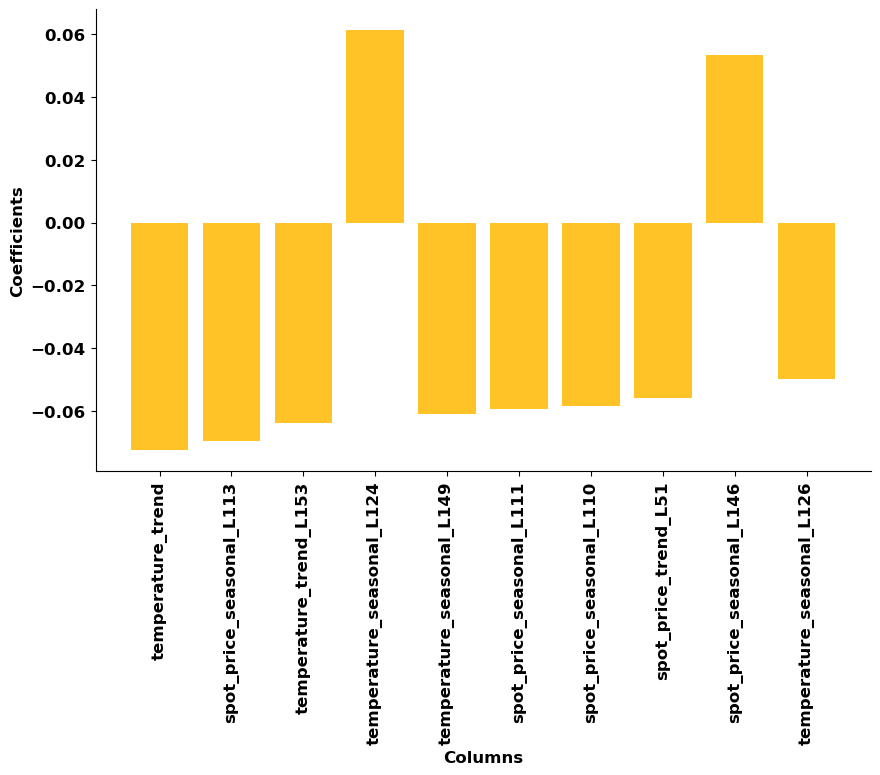

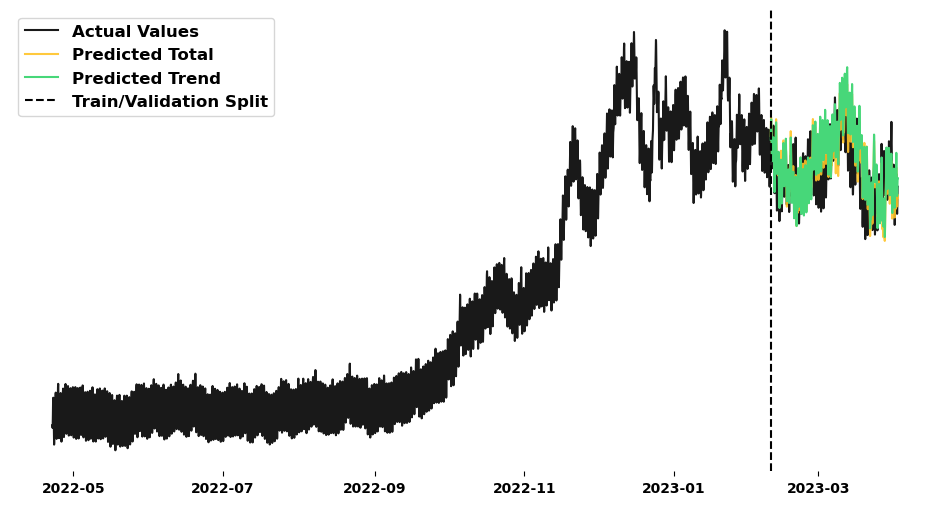

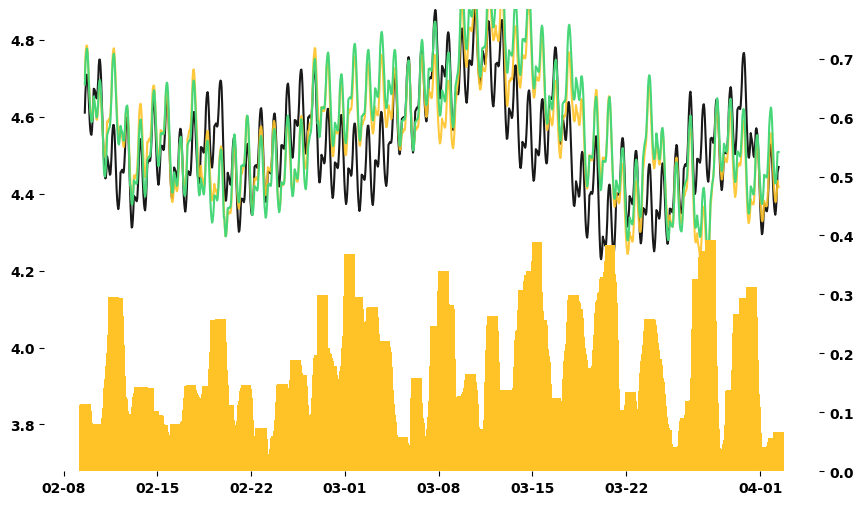

Error95: 0.04900278659438236
Out of sample MAPE: 2.0616552663973833
Mean oveprediction: 2.3355987584946925
Mean underprediction: 1.6943336724740627
MAPE with trend prediction only: 2.1993035148183266
Coefficients: 
is_holiday: -0.04011723934095099
is_weekend: -0.017015704487545982
hour: 0.009128399422318013
month: 0.039687696513178626
temperature_trend: -0.09290308396817702
temperature_seasonal: -0.014651524804829912
spot_price_trend: 0.0037029188134268553
spot_price_seasonal: -0.009359676010547954
temperature_trend_L38: -0.054457283135172216
temperature_trend_L39: -0.010893792426991747
temperature_trend_L40: 0.0014674043109969741
temperature_trend_L41: 0.005163323510168155
temperature_trend_L42: -0.009947121703378331
temperature_trend_L43: -0.004730774941025083
temperature_trend_L44: 0.0055146575220625035
temperature_trend_L45: 0.010204171254926895
temperature_trend_L46: -0.00861246075839933
temperature_trend_L47: -0.015355281256440692
temperature_trend_L48: 0.013722164681875757
tempe

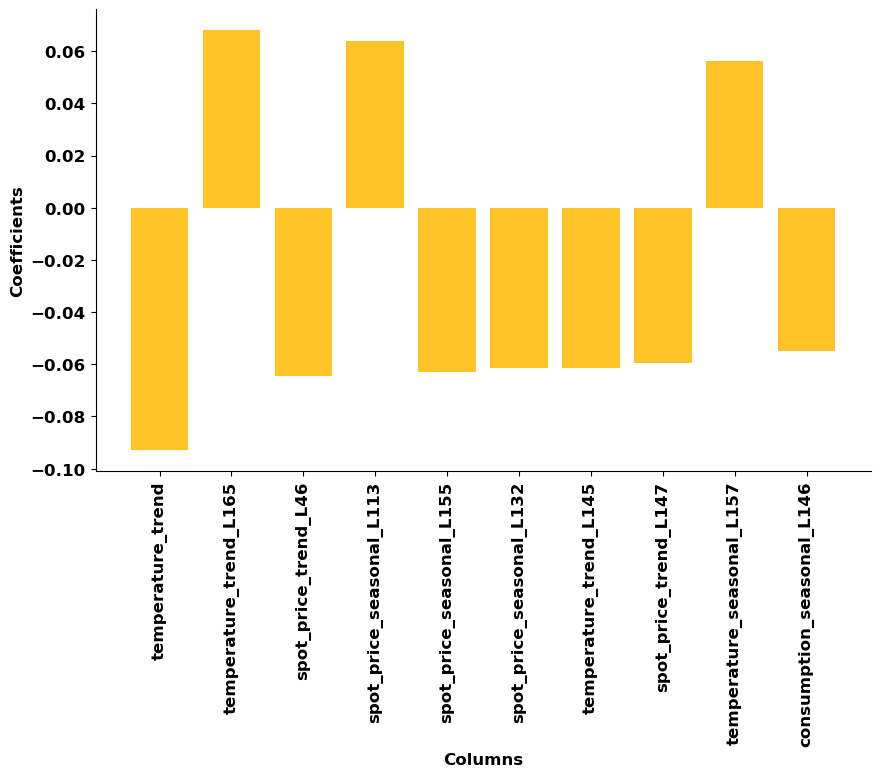

Trondheim
Alpha1, alpha2, MAPEfac, initVarianceFac abs_softness--> MAPE
4.76837158203125e-07 1.52587890625e-05 10 100 0.5--> 2.6073909536081916
4.76837158203125e-07 1.52587890625e-05 10 100 2--> 2.2613518875288734
4.76837158203125e-07 1.52587890625e-05 10 100 4--> 3.2973258422030622
4.76837158203125e-07 6.103515625e-05 10 100 0.5--> 2.031213915448799
4.76837158203125e-07 6.103515625e-05 10 100 2--> 2.544912553158077
4.76837158203125e-07 6.103515625e-05 10 100 4--> 2.8416392603477836
4.76837158203125e-07 0.000244140625 10 100 0.5--> 3.0172138372933617
4.76837158203125e-07 0.000244140625 10 100 2--> 3.2412943839299047
4.76837158203125e-07 0.000244140625 10 100 4--> 2.5832066701277667
4.76837158203125e-07 0.0009765625 10 100 0.5--> 2.946058714281112
4.76837158203125e-07 0.0009765625 10 100 2--> 2.9359457540451905
4.76837158203125e-07 0.0009765625 10 100 4--> 2.9505476077043373
3.814697265625e-06 1.52587890625e-05 10 100 0.5--> 2.595739864899788
3.814697265625e-06 1.52587890625e-05 10 100 

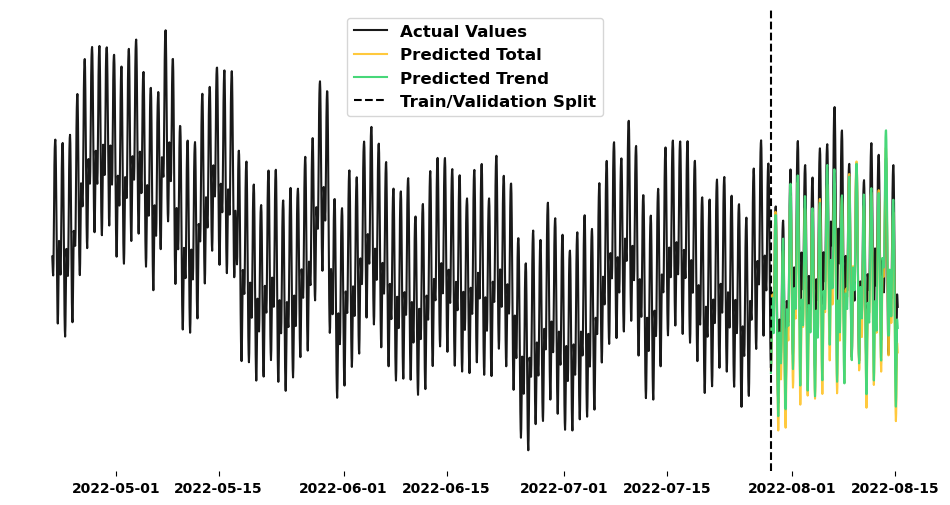

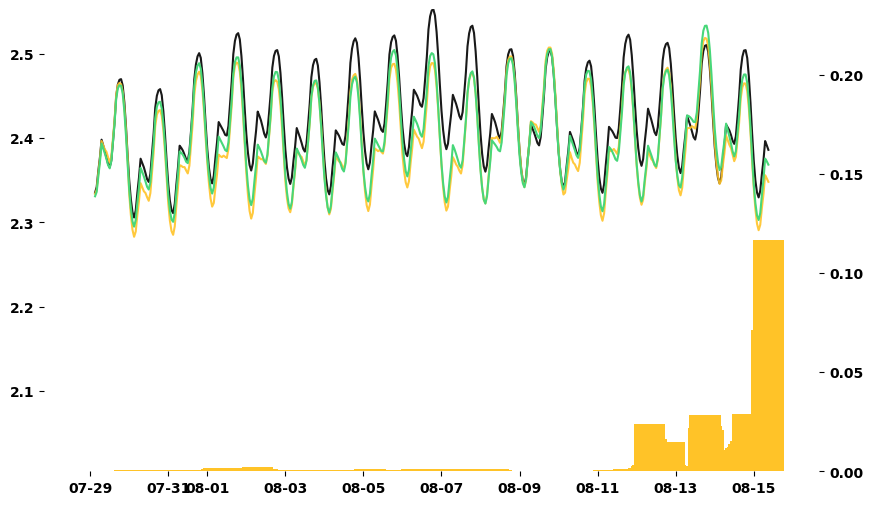

Error95: 0.024489804556122027
Out of sample MAPE: 1.163519991558603
Mean oveprediction: 0.31090588012045683
Mean underprediction: 1.269807929569862
MAPE with trend prediction only: 0.9588384101471061
Coefficients: 
is_holiday: -0.014231315709387038
is_weekend: 0.003880413657320497
hour: 0.0016018259211350377
month: -0.020560340620548484
temperature_trend: -0.04548228878051085
temperature_seasonal: 0.0020878272604430283
spot_price_trend: 0.011005784094434918
spot_price_seasonal: 0.001654943780913763
temperature_trend_L38: -0.029061481562751613
temperature_trend_L39: -0.005430139260076369
temperature_trend_L40: 0.004172863432192069
temperature_trend_L41: 0.007086508757718107
temperature_trend_L42: -0.020810672398030985
temperature_trend_L43: 0.0026728113701942366
temperature_trend_L44: -0.010417087193029705
temperature_trend_L45: 0.00885429282799618
temperature_trend_L46: 0.0005190508271379563
temperature_trend_L47: 0.011664793961898966
temperature_trend_L48: -0.002198502160886064
temper

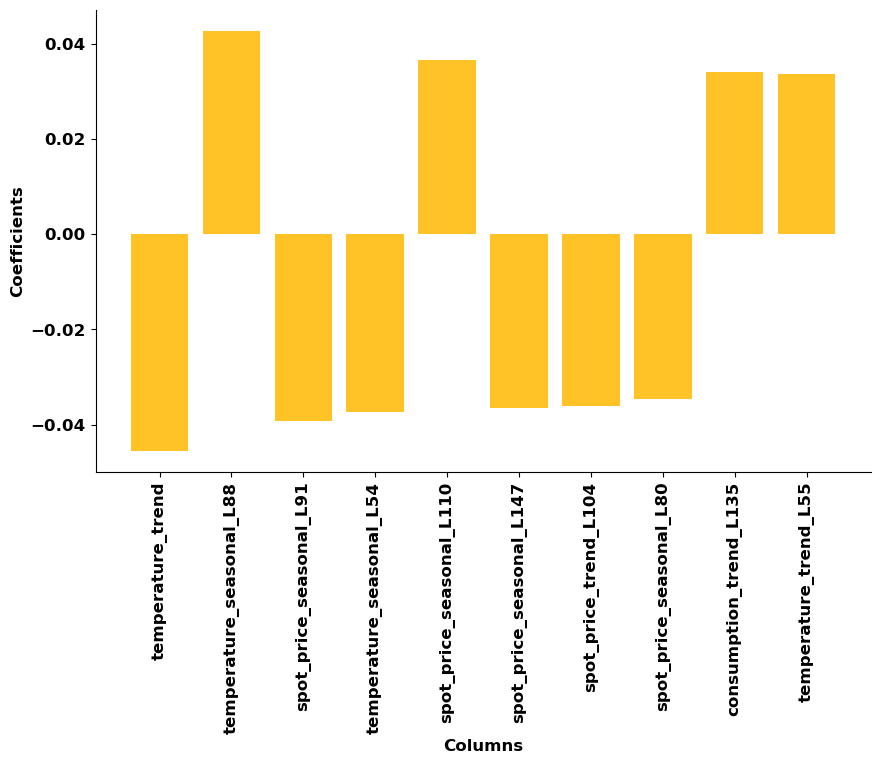

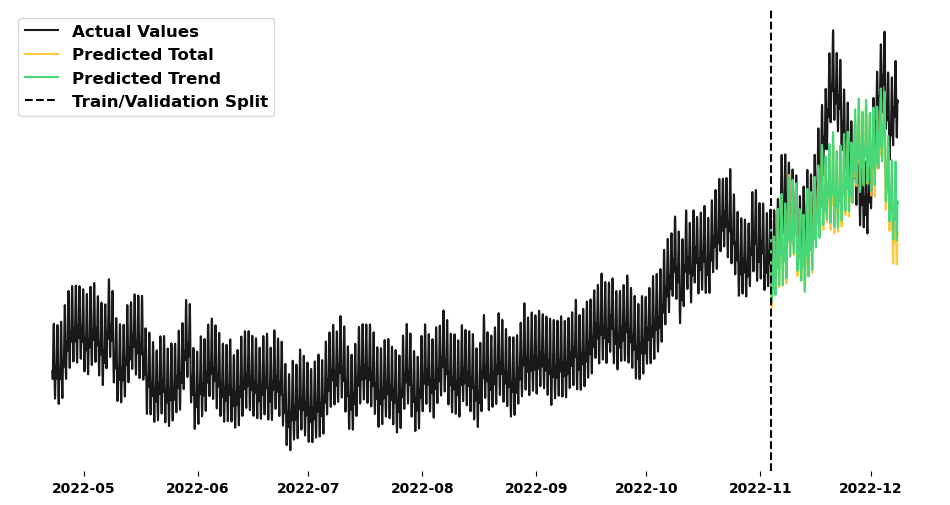

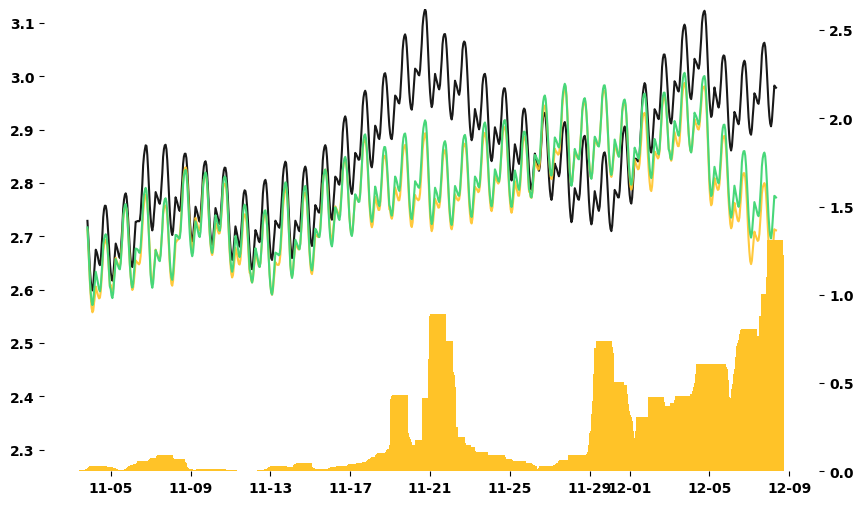

Error95: 0.0785231015638709
Out of sample MAPE: 3.2937340787806804
Mean oveprediction: 2.3331789122844033
Mean underprediction: 3.448445345093106
MAPE with trend prediction only: 2.981469619495324
Coefficients: 
is_holiday: -0.018956986088878212
is_weekend: 0.021537341883373695
hour: -0.001449947699530938
month: -0.00677408479148094
temperature_trend: -0.028814270928027342
temperature_seasonal: 0.007549925734220079
spot_price_trend: 0.014500835577114514
spot_price_seasonal: -1.2829256796805697e-05
temperature_trend_L38: 0.023519615062256825
temperature_trend_L39: 0.00259112302729328
temperature_trend_L40: -0.010224464226913315
temperature_trend_L41: -0.013140744186350759
temperature_trend_L42: -0.011509688038341738
temperature_trend_L43: -0.0077683803757058745
temperature_trend_L44: -0.00177649911083207
temperature_trend_L45: 0.020686890465719754
temperature_trend_L46: 0.010195617966677431
temperature_trend_L47: -0.020114358729433558
temperature_trend_L48: -0.009195159224419065
tempera

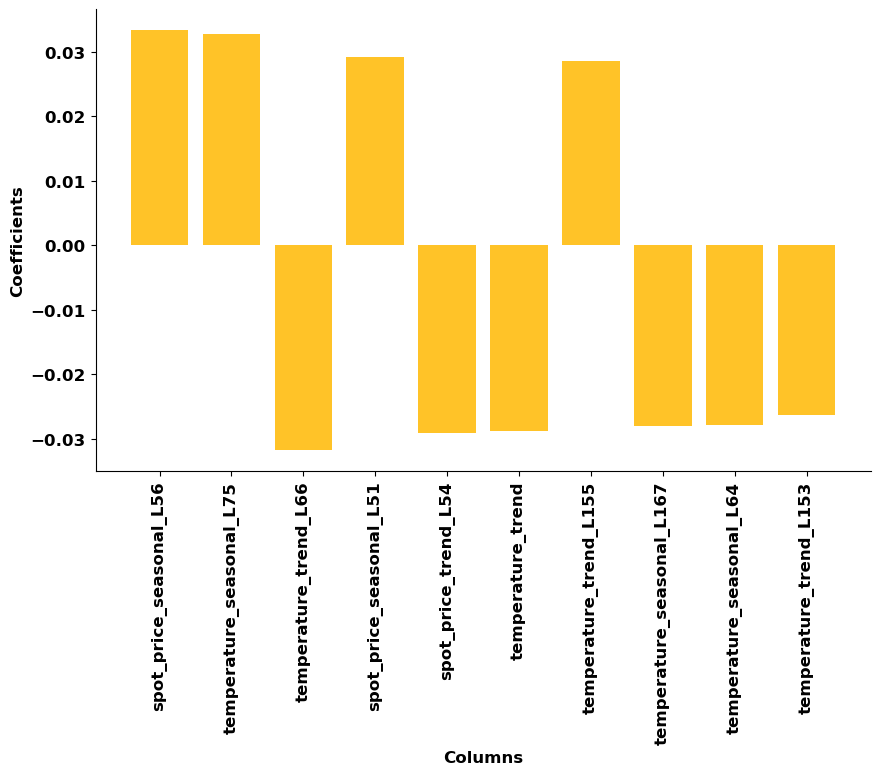

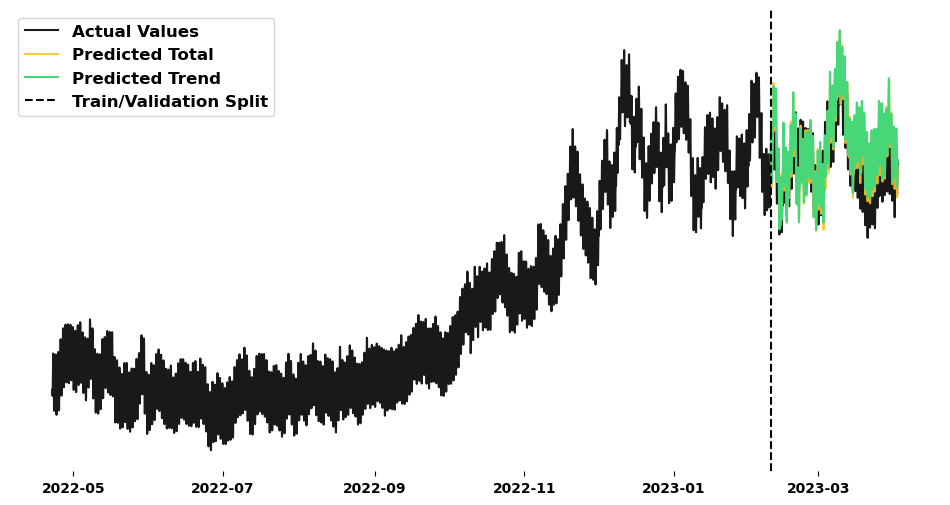

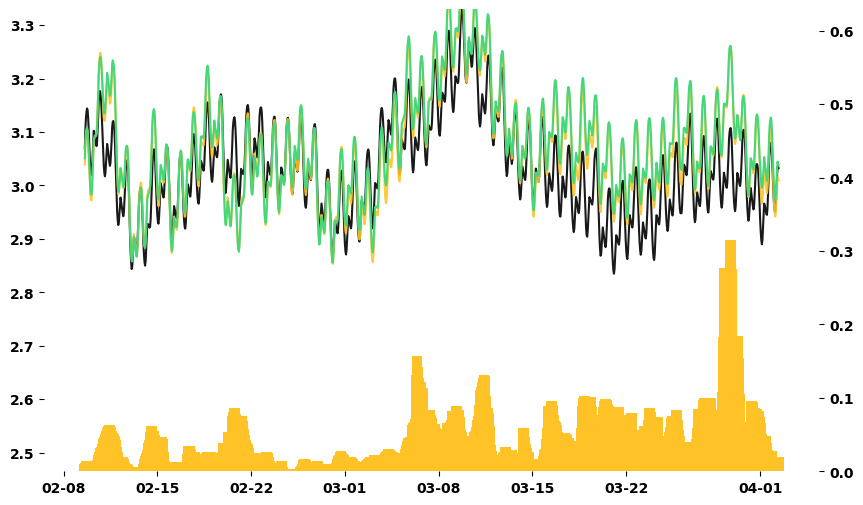

Error95: 0.037094610999012644
Out of sample MAPE: 1.745301703772516
Mean oveprediction: 1.989237733540306
Mean underprediction: 1.0648094256093226
MAPE with trend prediction only: 1.9406130966001207
Coefficients: 
is_holiday: -0.006110484060593796
is_weekend: -0.010221651798991557
hour: -0.00497275196196349
month: 0.008814911251149573
temperature_trend: -0.1450069194772714
temperature_seasonal: -0.03274841363939698
spot_price_trend: 0.0135037351209156
spot_price_seasonal: 0.01417493068056293
temperature_trend_L38: -0.030742783636307537
temperature_trend_L39: -0.005676848359093309
temperature_trend_L40: -0.018946883935011285
temperature_trend_L41: 0.005165061127668777
temperature_trend_L42: 0.015692386350113732
temperature_trend_L43: -0.004546042307795237
temperature_trend_L44: -0.016235618444450615
temperature_trend_L45: -0.004176992272349825
temperature_trend_L46: 0.007940560111446804
temperature_trend_L47: 0.012919867861693723
temperature_trend_L48: -0.011406114677971793
temperature_

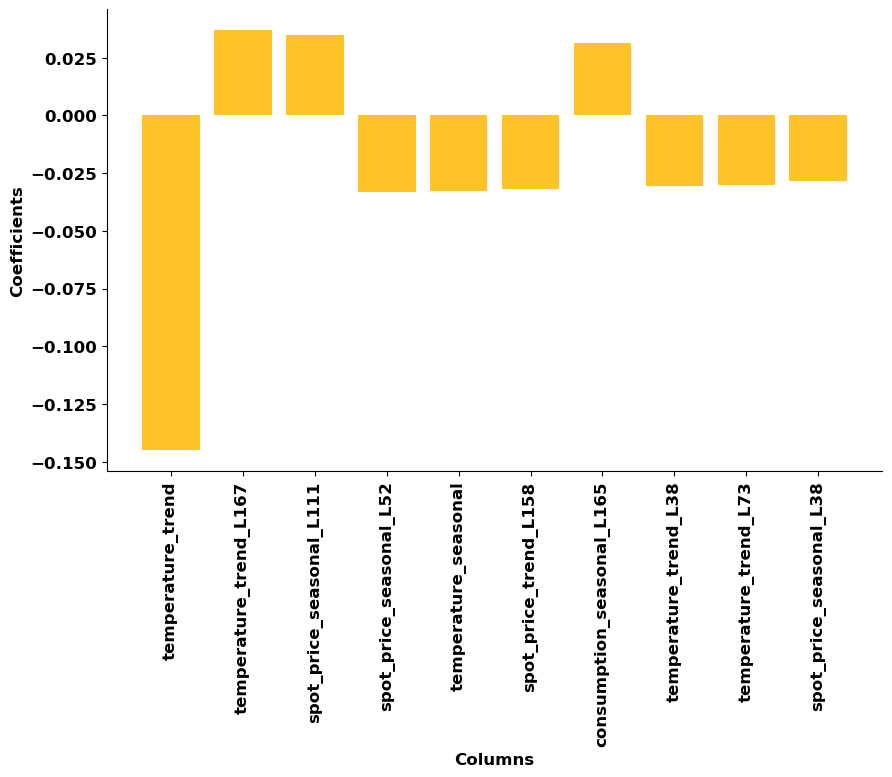

Tromsø
Alpha1, alpha2, MAPEfac, initVarianceFac abs_softness--> MAPE
4.76837158203125e-07 1.52587890625e-05 10 100 0.5--> 2.38502242235761
4.76837158203125e-07 1.52587890625e-05 10 100 2--> 3.0439501533151017
4.76837158203125e-07 1.52587890625e-05 10 100 4--> 2.97947809989495
4.76837158203125e-07 6.103515625e-05 10 100 0.5--> 2.3603187406853556
4.76837158203125e-07 6.103515625e-05 10 100 2--> 2.68456321403202
4.76837158203125e-07 6.103515625e-05 10 100 4--> 2.364651617221798
4.76837158203125e-07 0.000244140625 10 100 0.5--> 2.851234172293404
4.76837158203125e-07 0.000244140625 10 100 2--> 2.737812041898163
4.76837158203125e-07 0.000244140625 10 100 4--> 2.324405539483191
4.76837158203125e-07 0.0009765625 10 100 0.5--> 2.851498948809343
4.76837158203125e-07 0.0009765625 10 100 2--> 2.9028233099470886


KeyboardInterrupt: 

In [156]:
CV = True
for I in range(5):
    data=DFS[I]
    print(DF_STRINGS[I])
    mu, sig = REVERSE_CONSUMPTION_NORMALIZATION[I]

    alpha1s = [2**(-21),2**(-18),2**(-15),2**(-12)]
    alpha2s = [2**(-16),2**(-14), 2**(-12),2**(-10)]
    MAPEfacs = [10]
    initVarianceFacs = [100]
    abs_softnesses =[0.5,2,4]

    alpha1smanual = [2**(-12),2**(-18),2**(-18),2**(-18),2**(-18)]
    alpha2smanual = [2**(-8),2**(-16),2**(-10),2**(-16),2**(-10)]
    MAPEfacsmanual = [10,10,10,10,10]
    initVarianceFacsmanual = [50,75,75,75,75]
    abs_softnessesManual = [2,2,2,2,2]

    if CV:
        # Grid Search
        best_mape = float('inf')
        best_hyperparams = None

        print("Alpha1, alpha2, MAPEfac, initVarianceFac abs_softness--> MAPE")
        for alpha1 in alpha1s:
            for alpha2 in alpha2s:
                for MAPEfac in MAPEfacs:
                    for initVarianceFac in initVarianceFacs:
                        for abs_softness in abs_softnesses:
                            average_mape = cross_validate(data,alpha1,alpha2,mu,sig,MAPEfac,initVarianceFac,abs_softness,I)
                            print(f"{alpha1} {alpha2} {MAPEfac} {initVarianceFac} {abs_softness}--> {average_mape}")
                            # Update best hyperparameters if current MAPE is lower
                            if average_mape < best_mape:
                                best_mape = average_mape
                                best_hyperparams = (alpha1,alpha2,MAPEfac,initVarianceFac, abs_softness)

        print(f'Best Hyperparameters: {best_hyperparams}')
        print(f'Best CV MAPE: {best_mape}%')
    else:
        best_hyperparams = (alpha1smanual[I],alpha2smanual[I],MAPEfacsmanual[I],initVarianceFacsmanual[I],abs_softnessesManual[I])

    tol = 1e-4
    L = len(data)
    k=3
    offsets = range(1,L,int(np.floor(L/k)))
    for offset in offsets:
        X = data.iloc[0:int(offset + np.floor(L/k))]
  
        y1 = X["consumption_seasonal"]
        y2 = X["consumption_trend"]
        X = X.drop(columns=["consumption_seasonal", "consumption_trend"])

        X_train, X_val = custom_train_val_split(X, VAL_SPLIT)
        y1_train, y1_val = custom_train_val_split(y1, VAL_SPLIT)
        y2_train, y2_val = custom_train_val_split(y2, VAL_SPLIT)

        # Lasso with MAPE Loss
        def lasso_mape_loss(w, X, y_true, alpha):
            F=best_hyperparams[4]
            v = generate_weight_vector(y_true)
            y_pred = X @ w
            return np.mean(v*soft_abs((y_true - y_pred)/(y_true+best_hyperparams[2]),F)) + alpha * (np.sum(soft_abs(w,2**(-31)))/np.mean(y_true+best_hyperparams[2]))

        n_features = X_train.shape[1]
        
        w_initial1 = np.random.randn(n_features)/best_hyperparams[3] # Set small coefficients to zero, add noise 
        w_initial2 = np.random.randn(n_features)/best_hyperparams[3] # Set small coefficients to zero, add noise 
        result = minimize(lasso_mape_loss, w_initial1, args=(X_train, y1_train, best_hyperparams[0]), method='L-BFGS-B', options={'tol':tol})
        w_optimal_1 = result.x
        result = minimize(lasso_mape_loss, w_initial2, args=(X_train, y2_train, best_hyperparams[1]), method='L-BFGS-B', options={'tol':tol})
        w_optimal_2 = result.x

        y1_pred = X_val @ w_optimal_1
        y2_pred = X_val @ w_optimal_2

        train_pred1 = X_train @ w_optimal_1
        train_pred2 = X_train @ w_optimal_2

        actual = (y1 + y2)
        full_preds = np.concatenate(((train_pred1 + train_pred2).T,(y1_pred + y2_pred).T)).T
        mu, sig = REVERSE_CONSUMPTION_NORMALIZATION[I]

        y_seas, y_trend =  X_val["consumption_seasonal_L168"], X_val["consumption_trend_L168"]
        y_seas_all, y_trend_all =  X["consumption_seasonal_L168"], X["consumption_trend_L168"]
        
        # Create an array of indices for plotting
        xs = X.index
        xs_train = X_train.index
        xs_oos = X_val.index

        # Plot actual values and predictions
        plt.figure(figsize=(12, 6))
        plt.plot(xs, (actual+y_seas_all+y_trend_all) * sig + mu, label='Actual Values', color='black', alpha=0.9)
        #plt.plot(xs_train, (train_pred1 + train_pred2) * sig + mu, label='In-sample predictions', color='#CFDDFF',alpha=0.9)
        plt.plot(xs_oos, (y1_pred + y2_pred+y_seas+y_trend) * sig + mu, label='Predicted Total', color='#FFC328', alpha=0.9)
        plt.plot(xs_oos, (y2_pred+y_seas+y_trend) * sig + mu, label='Predicted Trend', color='#47D779')
        plt.axvline(xs[len(train_pred1)], linestyle='--', color='black', label='Train/Validation Split')
        #plt.title(f"Lasso Predictions vs Actual Values - {DF_STRINGS[I]}")
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['bottom'].set_visible(False)
        plt.gca().spines['left'].set_visible(False)
        #plt.xlabel('Time')
        plt.xticks(fontweight='bold')
        plt.yticks([])
        #plt.ylabel('Values')
        plt.legend()
        legend = plt.legend(fontsize='12')
        for text in legend.get_texts():
            text.set_fontweight('bold')
        plt.show()

        ys = pd.DataFrame(y1_val+y2_val)
        temp = DFS_orig[I].merge(ys , how = "inner", right_index=True, left_index=True)
        monetary_exposure = np.abs((y1_val+y2_val - (y1_pred+y2_pred))*sig)*temp["spot_price"] 

        # Plot only oos values and predictions
        fig,ax1 = plt.subplots(figsize=(10, 6))
        ax1.plot(xs_oos, (y1_val+y2_val+y_seas+y_trend) * sig + mu, label='Actual Values', color='black', alpha=0.9)
        #plt.plot(xs_train, (train_pred1 + train_pred2) * sig + mu, label='In-sample predictions', color='#CFDDFF',alpha=0.9)
        ax1.plot(xs_oos, (y1_pred + y2_pred+y_seas+y_trend) * sig + mu, label='Predicted Total', color='#FFC328', alpha=0.9)
        ax1.plot(xs_oos, (y2_pred+y_seas+y_trend) * sig + mu, label='Predicted Trend', color='#47D779')
        date_format = mdates.DateFormatter('%m-%d')  # Format: Month-Day
        ax1.xaxis.set_major_formatter(date_format)

        plt.xticks(fontweight='bold')
        plt.yticks(fontweight='bold')
        ax1.set_ylim([min((y1_val+y2_val+y_seas+y_trend) * sig + mu)/1.15, max((y1_val+y2_val+y_seas+y_trend) * sig + mu)])
        ax2 = plt.gca().twinx()
        ax2.bar(xs_oos, monetary_exposure, color='#FFC328', label='Monetary Exposure')#.set_ylim([0, 2*max(monetary_exposure)])
        ax2.set_ylim([0,2*max(monetary_exposure)])
        plt.yticks(fontweight='bold')

        #plt.title(f"Lasso Predictions vs Actual Values - {DF_STRINGS[I]}")
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.spines['bottom'].set_visible(False)
        ax1.spines['left'].set_visible(False)
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.spines['bottom'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        #plt.xlabel('Time')
        #plt.xticks(fontweight='bold')
        #plt.yticks(fontweight='bold')

        plt.show()

        resids = ((y1_val+y2_val)*sig - (y1_pred+y2_pred)*sig) / ((y1_val+y2_val+y_seas+y_trend)*sig+mu)
        oos_MAPE = np.mean(np.abs(resids)) * 100
        error_95 = np.percentile(np.abs(resids),95)
        print(f'Error95: {error_95}')
        mape_positive = resids[resids < 0].mean()*-100
        mape_negative = resids[resids > 0].mean()*100
        mape_trend = np.mean(np.abs(((y1_val+y2_val)*sig - (y2_pred)*sig) / ((y1_val+y2_val+y_seas+y_trend)*sig+mu)))*100
        print(f"Out of sample MAPE: {oos_MAPE}")
        print(f"Mean oveprediction: {mape_positive}")
        print(f"Mean underprediction: {mape_negative}")
        print(f"MAPE with trend prediction only: {mape_trend}")

        cols = X.columns
        coefs_total= (w_optimal_1+w_optimal_2)*sig
        print("Coefficients: ")
        for i in range(len(cols)):
            if np.abs(coefs_total[i])>0:
                print(f"{cols[i]}: {coefs_total[i]}")
        print(f"Number of features: {np.sum(np.where(np.abs(coefs_total)>10**(-2),1,0))}")

        combined_list = list(zip(cols, coefs_total))

        # Sorting by the absolute value of coefficients
        sorted_list = sorted(combined_list, key=lambda x: abs(x[1]), reverse=True)
        top_10 = sorted_list[:10]
        top_cols, top_coefs = zip(*top_10)
        plt.figure(figsize=(10, 6))
        plt.bar(top_cols, top_coefs, color='#FFC328')
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['bottom'].set_visible(True)
        plt.gca().spines['left'].set_visible(True)
        #plt.title(f"Top 10 Important Features by Coefficient - {DF_STRINGS[I]}")
        plt.xlabel('Columns', fontweight='bold', fontsize=12)
        plt.ylabel('Coefficients', fontweight='bold', fontsize=12)
        plt.xticks(rotation=90)  # Rotates the x-axis labels for better readability
        plt.xticks(fontweight='bold', fontsize=12)
        plt.yticks(fontweight='bold', fontsize=12)
        plt.show()


        